### Yammer analysts have found a recent dip in user engagement. In this data challenge, we will attempt to drill in and see whether we can explain the source of the problem.

Overall we have not found a clear cause for the dip. We have been able to replicate the finding of the analysts, that a dip in engagement has occured, and we found that it is **not** explained by:

1) A drop in the rate of new users.

2) A drop in users of any one company from the service.

3) A drop in users from a specific country.


### The notebook is organized as follows:

1) Problem statement and hypotheses.

2) Data loading, cleaning.

3) Ruling out the first hypothesis related to new users.

4) Ruling out some subsets of the second hypothesis.

#### A few hypotheses:

1) There has been no drop in retention, however new users have stopped coming in. We are now facing a retention and growth problem.

2) New user growth has not slowed down, but retention is significantly down, because some subset of users have stopped using Yammer (novice users? veteran users? perhaps some other demographic). 

3) Similar to (2), but in this case **most** users have slowed their usage.

Note that the hypotheses are not exclusive to one another, but any one of them could be an explanation for the problem.

Separating retention and growth seems like a good first step to undestand the data. If we then find that retention is truly the problem, we will be able to drill in and compare (2) and (3), and perhaps even get more specific.

### Grabbing the data and initial exploration using pandas_profiling

In [1]:
#upload the data
import pandas as pd
users = pd.read_csv("yammer_users.csv", parse_dates=True)
events = pd.read_csv("yammer_events.csv", parse_dates=True)
emails = pd.read_csv("yammer_emails.csv", parse_dates=True)
dims = pd.read_csv("dimension_rollup_periods.csv")

In [2]:
#impute all unactivated users with a future date (as we may still need to reference them later)
users.fillna('2020-01-01 00:00:00', inplace=True)

In [3]:
#we need to convert dates, which are currently strings, into a more useful format. I will convert to "Days since 2013"
from datetime import datetime

def appendDaysDelta(dataframe, colName, dateTimeFormat='%Y-%m-%d %H:%M:%S', 
                    dayZero=datetime(2013, 1, 1), newColName='_days_since_2013', divide=1):
    newCol = dataframe[[colName]].applymap(lambda d: datetime.strptime(d, dateTimeFormat))
    newCol = newCol.applymap(lambda d: round((d-dayZero).days/divide))
    dataframe[colName + newColName] = newCol.iloc[:,0]
    

In [4]:
#we can now use this to calculate number of days since 2013
appendDaysDelta(users, 'created_at')
appendDaysDelta(users, 'activated_at')

In [5]:
appendDaysDelta(events, 'occurred_at')

In [6]:
engagements = events[events['event_type']=='engagement']

In [7]:
engagements['weeks_since_2013'] = engagements['occurred_at_days_since_2013'].apply(lambda col: round(col/7)).values

/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
engagements.drop_duplicates(['user_id', 'weeks_since_2013'], inplace=True)

/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
#be careful not to plots the last week, which has partial data
engagements.groupby('weeks_since_2013').count().iloc[:-1,:].plot()

#### Now we have essentially the same plot as in the Yammer dashboard.

#### We can generate similar plots for new users and activations:

In [10]:
users['created_weeks_since_2013'] = users['created_at_days_since_2013'].apply(lambda col: round(col/7)).values

In [11]:
users['activated_weeks_since_2013'] = users['activated_at_days_since_2013'].apply(lambda col: round(col/7)).values

In [12]:
recentUsers = users[users['created_weeks_since_2013'] > 68]

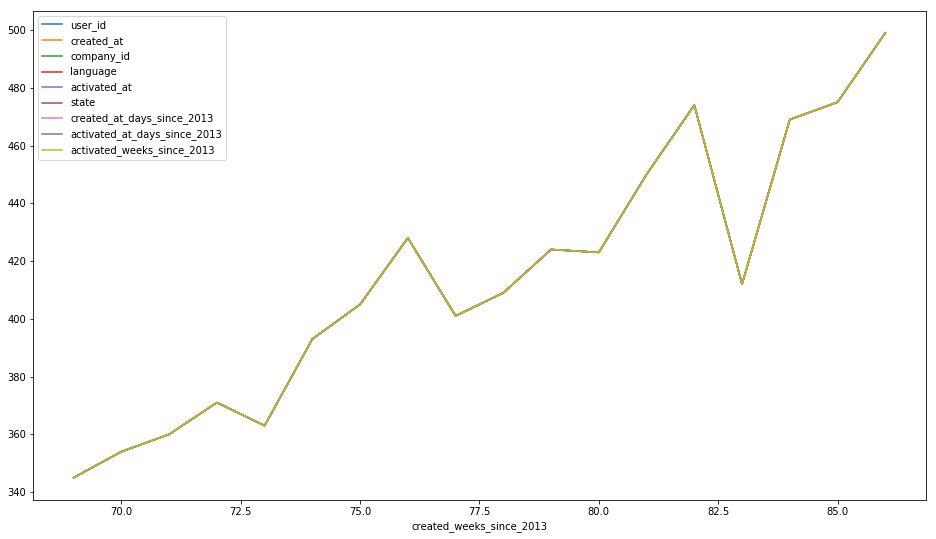

In [13]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
recentUsers.groupby('created_weeks_since_2013').count().iloc[:-1,:].plot()

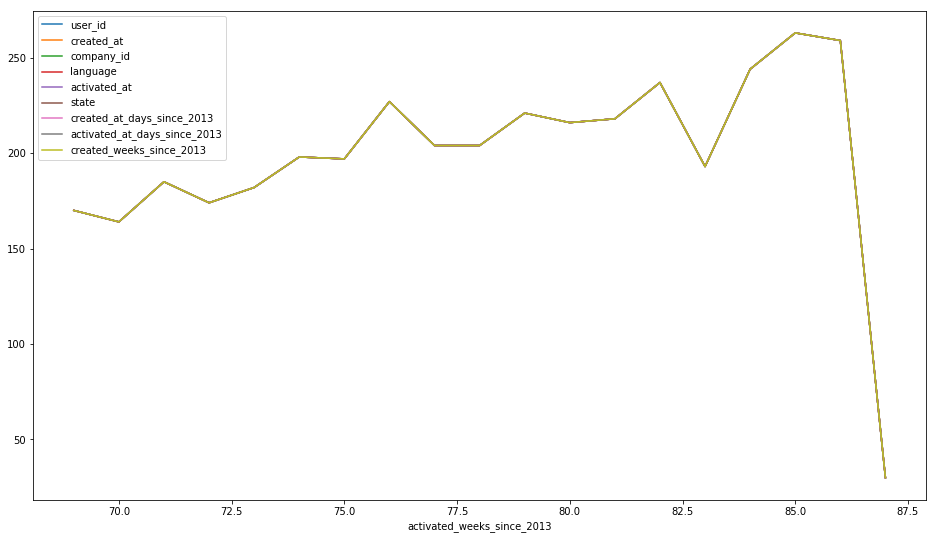

In [14]:
recentUsers.groupby('activated_weeks_since_2013').count().iloc[:-1,:].plot()

### We can rule out the first hypothesis. 

Even though there is some interesting data for recent activations and subscriptions, it cannot fully account for the magnitude of lost active users, which is ~200. The drop in new subscriptions is thus likely correlated rather than causal.

We can now look at the **second hypothesis**, which is that a certain demographic has dropped in usage. 


### We can test for whether:

1) One large company has stopped using Yammer, or perhaps a few medium ones.

2) Certain language users have dropped off, or certain geographic locations.

3) Users who use certain devices have stopped logging in.

We only have time for a limited exploration of these possiblities. Begin with companies.

In [15]:
#merge tables to get the company_id into engagements table
engagements_companies = pd.merge(engagements, users[['user_id', 'company_id']], how='left', on='user_id', sort=False)

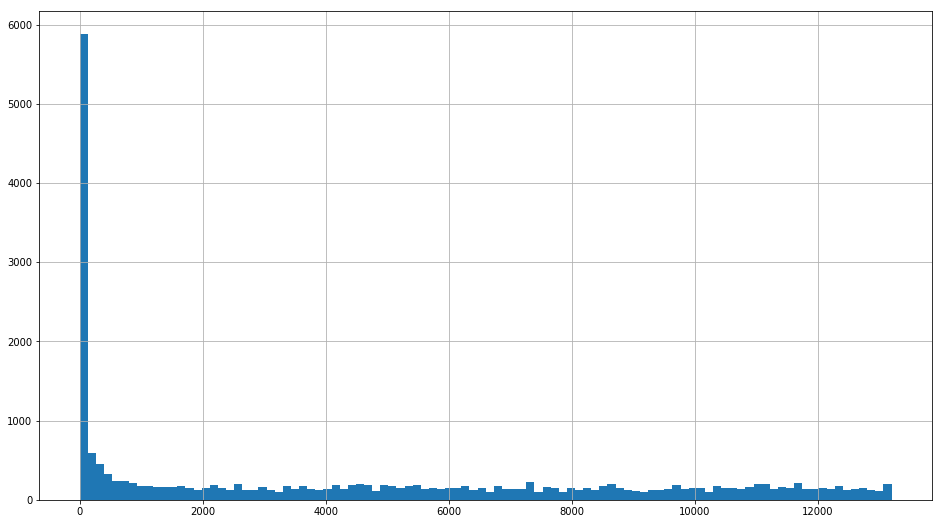

In [16]:
engagements_companies.company_id.hist(bins=100)

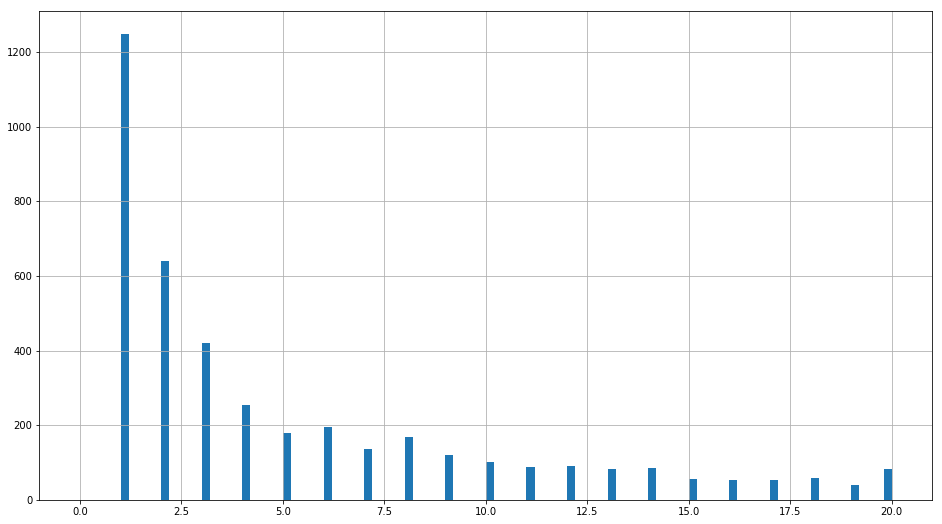

In [17]:
engagements_companies.company_id.hist(bins=100, range=(0, 20))

In [18]:
engagements_before = engagements_companies[engagements_companies['weeks_since_2013'] < 83]
engagements_after = engagements_companies[engagements_companies['weeks_since_2013'] >= 83]

(array([0.16129032, 0.12752016, 0.05745968, 0.03024194, 0.04032258,
        0.02217742, 0.01360887, 0.01360887, 0.01209677, 0.02167339]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 1 Patch objects>)

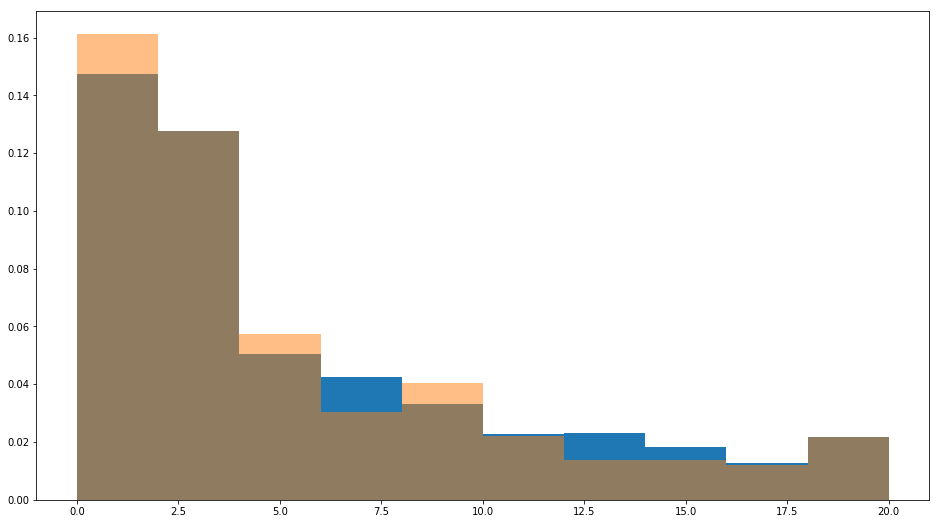

In [19]:
import matplotlib.pyplot as plt

companies_before = engagements_before.company_id.values
companies_after = engagements_after.company_id.values

plt.hist(companies_before, density=True, range=(0,20), histtype='stepfilled')
plt.hist(companies_after, density=True, range=(0,20), alpha=0.5, histtype='stepfilled')

#### Clearly no single company can be responsible for the dip in engagement.

#### We can now check for geographic locations that may be responsible:

In [20]:
locations_before = engagements_before.location.values
locations_after = engagements_after.location.values

from collections import Counter
beforeCounts = Counter(locations_before)
beforeCounts = beforeCounts.most_common()[:20]

afterCounts = Counter(locations_after)
afterCounts = afterCounts.most_common()[:20]

In [21]:
beforeCounts

[('United States', 4706),
 ('Japan', 1218),
 ('Germany', 1074),
 ('France', 837),
 ('United Kingdom', 782),
 ('Italy', 623),
 ('Russia', 580),
 ('Brazil', 567),
 ('India', 521),
 ('Canada', 499),
 ('Mexico', 458),
 ('Korea', 383),
 ('Australia', 374),
 ('Spain', 304),
 ('Indonesia', 279),
 ('Netherlands', 227),
 ('Saudi Arabia', 224),
 ('Sweden', 183),
 ('Belgium', 162),
 ('Switzerland', 161)]

In [22]:
afterCounts

[('United States', 1487),
 ('Japan', 398),
 ('Germany', 337),
 ('United Kingdom', 236),
 ('France', 223),
 ('Italy', 199),
 ('Russia', 182),
 ('Brazil', 181),
 ('India', 142),
 ('Mexico', 129),
 ('Canada', 127),
 ('Australia', 116),
 ('Korea', 104),
 ('Spain', 91),
 ('Indonesia', 89),
 ('Netherlands', 81),
 ('Sweden', 62),
 ('Turkey', 53),
 ('Malaysia', 51),
 ('Switzerland', 51)]

#### Only the top few countries could have been responsible for the problem alone. It is clear that this is not the problem, since they have all maintained their order and relative importance.

While at this point I do not have time for further exploration, I would like to continue to drill in:

- It is possible that certain types of engagement are becoming less common. It can be useful to try to isolate a certain type of feature that people have been using less.

- It is also possible to continue testing for demographic data.

- If no such explanation prevails, it is likely that there has been a more or less uniform drop in engagement.